In [78]:
# Import
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats

**1. Pobieranie danych z Boston Housing Dataset**

In [79]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
dataset = pd.read_csv(url, delim_whitespace = True, names = names)

**2. EDA** <br>
Jak widać na poniższym wykresie w zbiorze danych istnieje kilka par zmiennych mogących być współliniowe np. NOX/DIS czy RAD/TAX. Jednak takich par jest niewiele, w większości przypadków wartość współczynnika korelacji jest na tyle mała, że wskazuje to na brak współliniowości.

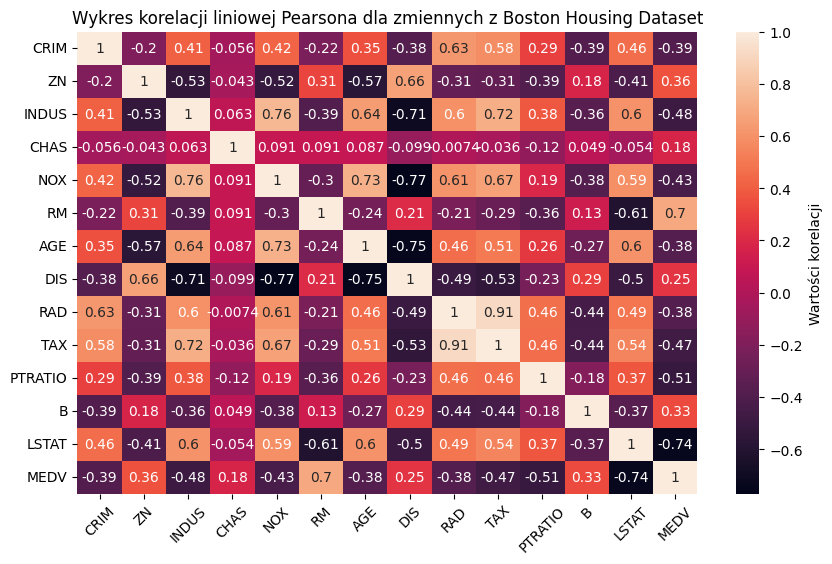

In [80]:
fig, ax = plt.subplots(1, figsize = (10, 6))
sns.heatmap(dataset.corr('pearson'), annot=True, cbar_kws={'label': 'Wartości korelacji'})
ax.tick_params(axis='x', rotation = 45)
ax.set_title("Wykres korelacji liniowej Pearsona dla zmiennych z Boston Housing Dataset");

**3. Podział zbioru danych na zbiór treningowy i testowy**

In [81]:
X = dataset.drop('MEDV', axis = 1)
y = dataset ['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**4. Tworzenie modelu regresji liniowej oraz modelu za pomocą gradient boostingu**

In [82]:
# Regresja liniowa
lr = LinearRegression()
lr.fit(X_train, y_train)

# XGBoost
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

**5. Zastosowanie GridSearchCV, aby dobrać optymalne hiperparametry dla modelu gradient boostingu**

In [83]:
params = {'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200]}
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3)
grid = GridSearchCV(estimator = xg_reg, param_grid = params, cv = 5, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best score: %f using params: %s" % (grid.best_score_, grid.best_params_))

Best score: -13.743169 using params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


**6. Porównanie wyników modeli na zbiorze testowym**

In [84]:
#Regresja liniowa
y_pred_lr = lr.predict(X_test)
print("Linear Regression- MSE:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression - MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression - R2:", r2_score(y_test, y_pred_lr))

# XGBoost
xg_reg = xgb.XGBRegressor(objective = "reg:squarederror", colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 3, n_estimators = 200)
xg_reg.fit(X_train, y_train)
y_pred_xg = xg_reg.predict(X_test)
print("XGBoost - MSE:", mean_squared_error(y_test, y_pred_xg))
print("XGBoost-MEA:", mean_absolute_error(y_test, y_pred_xg))
print("XGBoost - R2:", r2_score(y_test, y_pred_xg))

Linear Regression- MSE: 24.291119474973478
Linear Regression - MAE: 3.189091965887837
Linear Regression - R2: 0.6687594935356326
XGBoost - MSE: 8.981951933892145
XGBoost-MEA: 1.9956061232323743
XGBoost - R2: 0.8775195885604903


**7. Sprawdzenie założeń dla regresji liniowej**

*A) założenie liniowości* <br>
Jak widzimy założenie liniowości nie jest do końca spełnione dla każdej pary predyktor/zmienna objaśniana. Najbliższe istnienia takiej zależności, choć też nie do końca są pary LSTAT vs MEDV i RM vs MEDV.


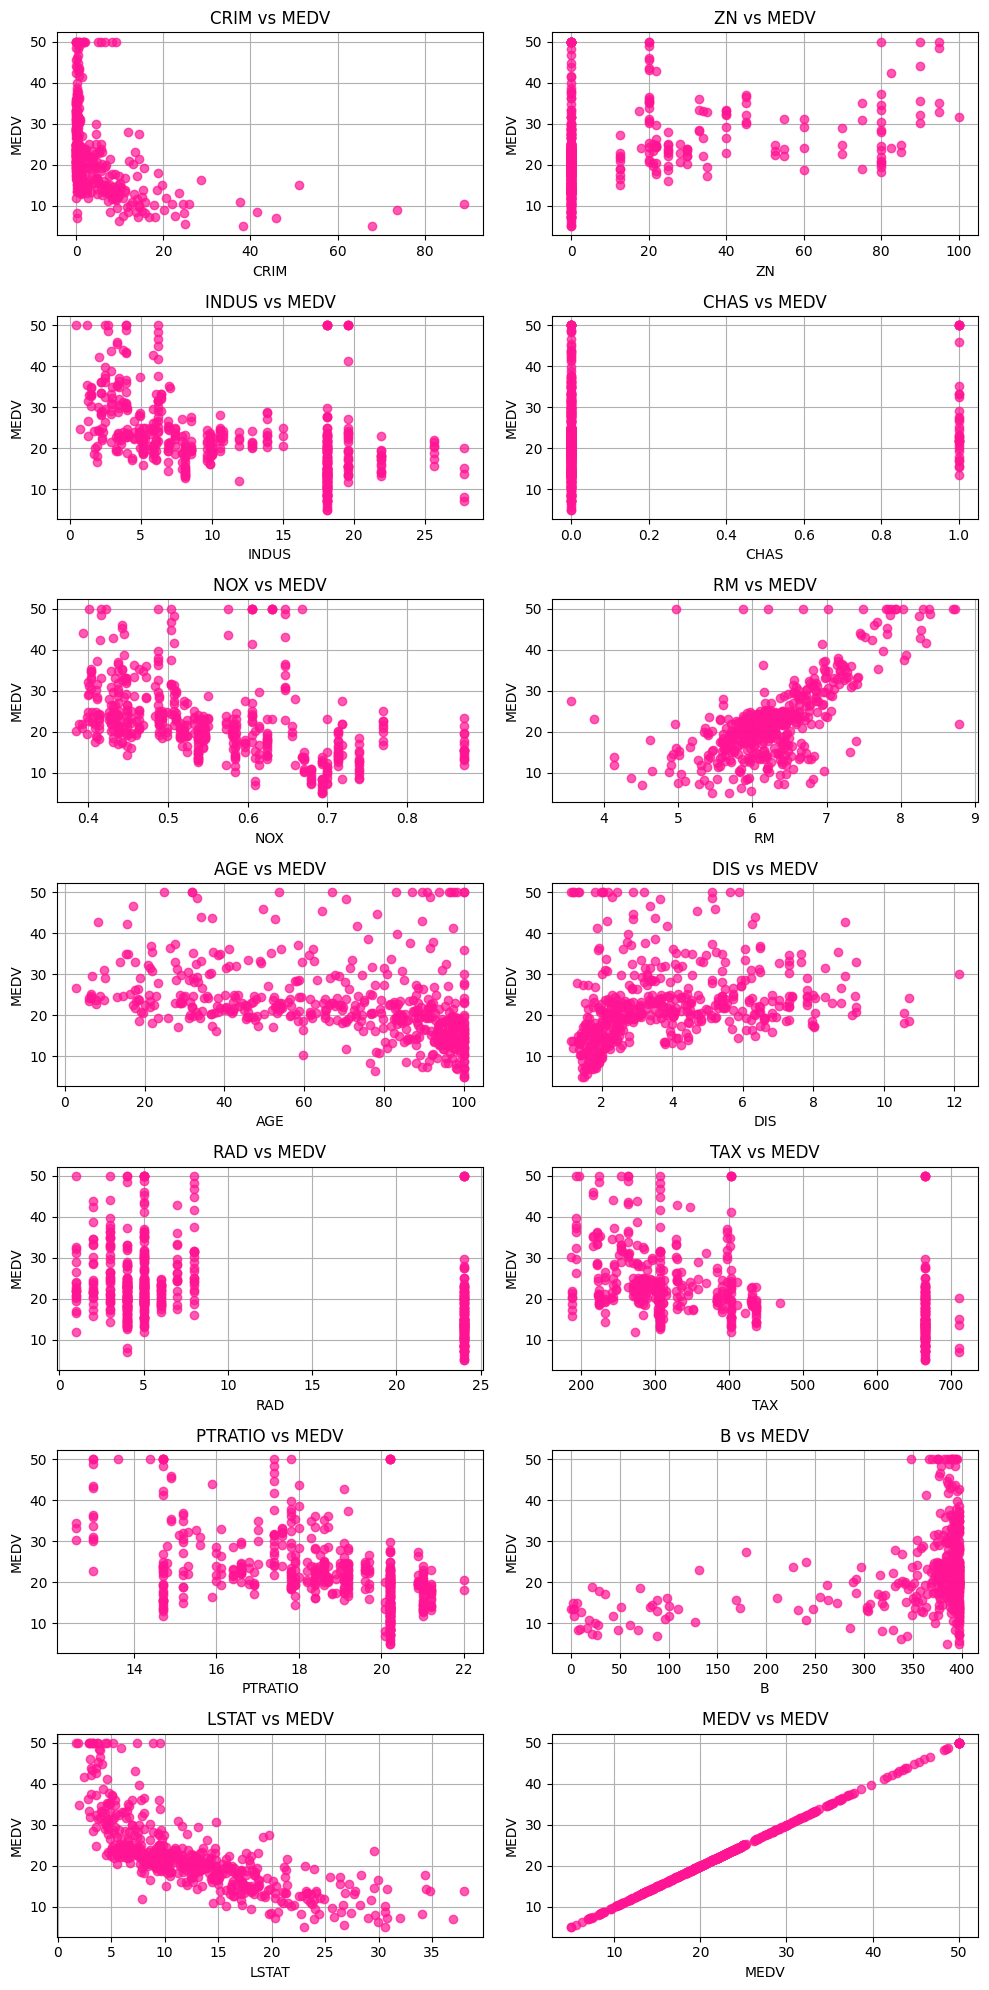

In [85]:
fig, ax = plt.subplots(7, 2, figsize=(10, 20))

for i, name in enumerate(names):
    ax[i//2, i%2].plot(dataset[name], dataset['MEDV'], 'o', color = 'deeppink', alpha = 0.7)
    ax[i//2, i%2].set_title(f'{name} vs MEDV')
    ax[i//2, i%2].set_xlabel(name)
    ax[i//2, i%2].set_ylabel('MEDV')
    ax[i//2, i%2].grid(True)

plt.tight_layout();

*B) założenie homoskedastyczności* <br>
Założenie to jest spełnione, ponieważ jak jest widoczne na wykresie reszty są równo rozproszone na całej długości pomiarowej.

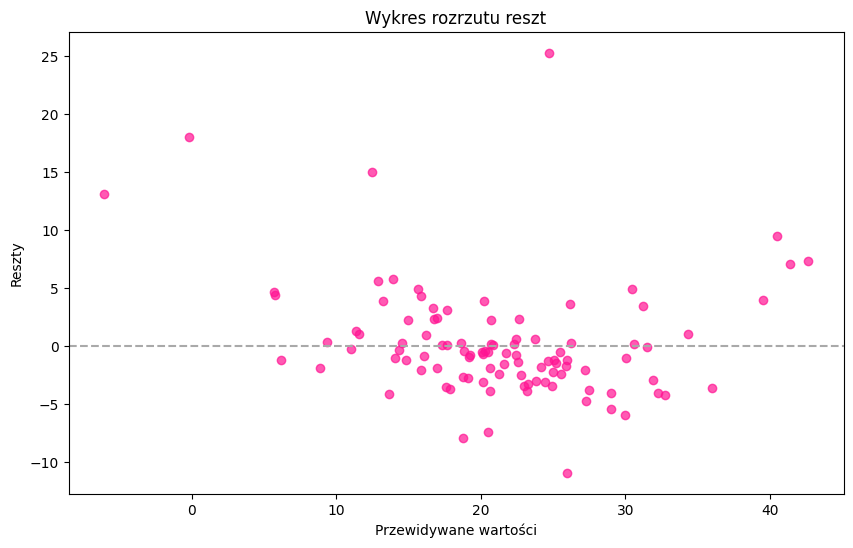

In [86]:
errors_lr = y_test - y_pred_lr
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(y_pred_lr, errors_lr, color = 'deeppink', alpha = 0.7)
ax.axhline(y = 0, color = 'darkgrey', linestyle = '--')
ax.set_title('Wykres rozrzutu reszt')
ax.set_xlabel('Przewidywane wartości')
ax.set_ylabel('Reszty');

*C) założenie o normalności reszt* <br>
Nie jest ono spełnione na co wskazuje oprócz rozkładu z wykresu powyżej, wynik testu Shapiro.

In [87]:
errors_lr = y_test - y_pred_lr
shapiro_test = stats.shapiro(errors_lr)
print("Wartość p dla testu Shapiro-Wilka:", shapiro_test.pvalue)

Wartość p dla testu Shapiro-Wilka: 1.990697606757408e-09
